segmentation: color dataset

In [0]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import os
import copy
import torch.utils.data as data_utils
import requests, zipfile, io
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

%matplotlib inline

In [0]:
url = 'https://www.via.cornell.edu/ece5470/Lab9data2.zip'
r=requests.get(url).content

#save data in data dir
z = zipfile.ZipFile(io.BytesIO(r))
# os.mkdir('data1')
z.extractall('./data1c')

In [0]:
""" Custom datatset loader
    based on https://github.com/utkuozbulak/pytorch-custom-dataset-examples
"""
import pandas as pd
import imageio

class SimpleDataset():
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=0)
       
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        a=single_image_name[:-3] + "png"
        single_image_name=a
        img_as_img = imageio.imread(self.data_path + single_image_name)
        # Open segmented mask
        a = single_image_name[:2] + "seg" + single_image_name[2:]
        imseg_name = a[:-3] + "png"
        imgsg_as_img = imageio.imread(self.data_path + imseg_name)
        
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        
        return (img_as_img, single_image_label, imgsg_as_img)

    def __len__(self):
        return self.data_len

In [4]:
mydata = SimpleDataset( "./data1c/", "labels.csv")

#splitting into images and labels 
X  = []
y  = []
Xs = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))
    Xs.append(mydata[i][2])


#converting into numpy arrays to enable easy reshaping and other array operations
    
X  = np.asarray(X)
Xs = np.asarray(Xs)
print("Shape of the input image", X.shape, Xs.shape)
y= np.asarray(y)

X  = np.swapaxes(X,1,3)
X  = np.swapaxes(X,2,3)
print("Shape of the input image", X.shape, Xs.shape,y.shape)

Shape of the input image (5000, 32, 32, 3) (5000, 32, 32)
Shape of the input image (5000, 3, 32, 32) (5000, 32, 32) (5000,)


In [5]:
Xtr=X[:3500,:,:,:]/255
Xstr=Xs[:3500,:,:]/255
ytr=y[:3500]

Xval=X[3500:4000,:,:,:]/255 #need to change validation size for 32x32 & 64x64 images
Xsval=Xs[3500:4000,:,:]/255
yval=y[3500:4000]

Xte=X[4000:5000,:,:,:]/255 #need to change test size for 32x32 & 64x64 images
Xste=Xs[4000:5000,:,:]/255
yte=y[4000:5000]


print(Xtr.shape,Xstr.shape,ytr.shape)
print(Xval.shape,Xsval.shape,yval.shape)
print(Xte.shape,Xste.shape,yte.shape)

(3500, 3, 32, 32) (3500, 32, 32) (3500,)
(500, 3, 32, 32) (500, 32, 32) (500,)
(1000, 3, 32, 32) (1000, 32, 32) (1000,)


Maximun value of ground truth image: 1.0
Minimum value of ground truth image: 0.0
Mean value of ground truth image: 0.0380


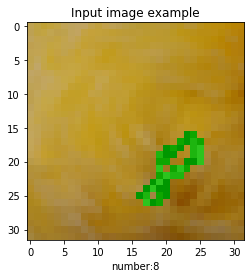

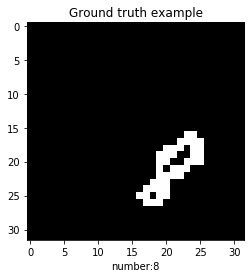

In [6]:
x=np.swapaxes(Xtr,1,3)
x=np.swapaxes(x,1,2)
plt.title("Input image example")
plt.xlabel("number:{}" .format(ytr[0]))
plt.imshow(x[0])

plt.figure()
plt.title("Ground truth example")
plt.xlabel("number:{}" .format(ytr[0]))
plt.imshow(Xstr[0],cmap='gray')

a=np.amax(Xstr)
print("Maximun value of ground truth image: {}" .format(a))
a=np.amin(Xstr)
print("Minimum value of ground truth image: {}" .format(a))
a=np.mean(Xstr)
print("Mean value of ground truth image: {:.4f}" .format(a))

In [7]:
batch_size = 8
'''
inputs and segs are your data. 
'''
targets=ytr

inputs = torch.from_numpy(Xtr).float()
targets = torch.from_numpy(targets).float()
segs    = torch.from_numpy(Xstr).float()

print('Size of inputs: {}'. format(inputs.shape))
print('Size of ground truth: {}'. format(segs.shape))
print(targets.shape)

# Dataloader
trainset = data_utils.TensorDataset(inputs, segs)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= batch_size, 
                                          shuffle=True, drop_last=True)

targets=yte

inputs = torch.from_numpy(Xte).float()
targets = torch.from_numpy(targets).float()
segs    = torch.from_numpy(Xste).float()

testset = data_utils.TensorDataset(inputs, segs)
testloader = torch.utils.data.DataLoader(testset, batch_size= batch_size, 
                                          shuffle=True, drop_last=True)

print('Size of inputs: {}'. format(inputs.shape))
print('Size of ground truth: {}'. format(segs.shape))
print(targets.shape)

targets=yval
inputs = torch.from_numpy(Xval).float()
targets = torch.from_numpy(targets).float()
segs    = torch.from_numpy(Xsval).float()

print('Size of inputs: {}'. format(inputs.shape))
print('Size of ground truth: {}'. format(segs.shape))
print(targets.shape)

# Dataloader
valset = data_utils.TensorDataset(inputs, segs)
val_loader = torch.utils.data.DataLoader(valset, batch_size= batch_size, 
                                          shuffle=False, drop_last=True)

Size of inputs: torch.Size([3500, 3, 32, 32])
Size of ground truth: torch.Size([3500, 32, 32])
torch.Size([3500])
Size of inputs: torch.Size([1000, 3, 32, 32])
Size of ground truth: torch.Size([1000, 32, 32])
torch.Size([1000])
Size of inputs: torch.Size([500, 3, 32, 32])
Size of ground truth: torch.Size([500, 32, 32])
torch.Size([500])


In [0]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

"""2D U-net Style"""
class conv_block(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3):
        super(conv_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size= kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(out_size)
        self.activation = F.relu
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size= kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(out_size)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)            
        out = self.activation(out)     
        return out

class up_block(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3):
        super(up_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size= kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(out_size)
        self.activation = F.relu
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size= kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(out_size)     
        
    def forward(self, x, skip= None):
        #print("")
        #print(x.shape)
        out = torch.cat([x, skip], 1)
        #print(out.shape)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)            
        out = self.activation(out)     
        return out   

class unet2D(nn.Module):
    def __init__(self):
        super(unet2D, self).__init__()
        self.activation = F.relu
        
        self.conv_block1 = conv_block(in_size= 3, out_size= 64)
        self.conv_block2 = conv_block(in_size= 64, out_size= 128)
        self.conv_block3 = conv_block(in_size= 128, out_size= 256)
        self.conv_block4 = conv_block(in_size= 256, out_size= 512)
        self.conv_block5 = conv_block(in_size= 512, out_size= 1024)
        
        self.down1 = nn.MaxPool2d(2)
        self.down2 = nn.MaxPool2d(2)
        self.down3 = nn.MaxPool2d(2)
        self.down4 = nn.MaxPool2d(2)

        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(512,  256, kernel_size=2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        self.up_block1 = up_block(in_size= 1024, out_size= 512)
        self.up_block2 = up_block(in_size= 512, out_size= 256)
        self.up_block3 = up_block(in_size= 256, out_size= 128)
        self.up_block4 = up_block(in_size= 128, out_size= 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size= 1, padding=0)
    
    def forward(self, x):
        skipA = self.conv_block1(x)
        out = self.down1(skipA)
        
        skipB = self.conv_block2(out)
        out = self.down2(skipB)
        
        skipC = self.conv_block3(out)
        out = self.down3(skipC)
        
        skipD = self.conv_block4(out)
        out = self.down4(skipD)
        
        out = self.conv_block5(out)
        
        out = self.up_conv1(out)
        out = self.up_block1(out,skip= skipD)
        
        out = self.up_conv2(out)
        out = self.up_block2(out,skip= skipC)        
        
        out = self.up_conv3(out)
        out = self.up_block3(out,skip= skipB)  
        
        out = self.up_conv4(out)
        out = self.up_block4(out,skip= skipA)
        
        out = self.final_conv(out)
        
        return F.sigmoid(out)

In [0]:
model = unet2D()

# Hyper parameters
num_epochs = 5   
num_classes = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [10]:
total_step = len(trainloader)
resultstr = []
resultsval = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        model.train()
        images = Variable(images)
        blabels1 = labels
        nlab=blabels1.view(-1,1,32,32)
        labels = Variable(nlab).type(torch.FloatTensor)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #Calcualte Dice coefficient
        out=outputs.data.numpy()
        out=np.reshape(out,(-1,32,32))
        out1=copy.deepcopy(out)
        out1[out1>0.5]=1
        out1[out1<=0.5]=0
        lab=labels.data.numpy()
        lab=np.reshape(lab,(-1,32,32))
        dice = np.sum(out1[lab==1])*2.0 / (np.sum(out1) + np.sum(lab))

        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 31 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], TrLoss: {:.4f}, TrDice: {:.4f}' 
                   .format(epoch+1,num_epochs,i+1, total_step, loss.item(), dice))
    resultstr.append([loss.item(),dice]) # keep them for further processing

    #Do validation
    for i, (images, labels) in enumerate(val_loader):
        model.eval()
        images = Variable(images,volatile=True)
        blabels1 = labels
        nlab=blabels1.view(-1,1,32,32)
        labels = Variable(nlab).type(torch.FloatTensor)
         
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
    
        #Calcualte Dice coefficient
        out=outputs.data.numpy()
        out=np.reshape(out,(-1,32,32))
        out1=copy.deepcopy(out)
        out1[out1>0.5]=1
        out1[out1<=0.5]=0
        lab=labels.data.numpy()
        lab=np.reshape(lab,(-1,32,32))
        dice = np.sum(out1[lab==1])*2.0 / (np.sum(out1) + np.sum(lab))
        
        if (i+1) % 31 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], ValLoss: {:.4f}, ValDice: {:.4f}' 
                   .format(epoch+1,num_epochs,i+1, total_step, loss.item(), dice))
    resultsval.append([loss.item(),dice]) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/5], Step [31/437], TrLoss: 0.2048, TrDice: 0.6110
Epoch [1/5], Step [62/437], TrLoss: 0.1256, TrDice: 0.7556
Epoch [1/5], Step [93/437], TrLoss: 0.0744, TrDice: 0.9167
Epoch [1/5], Step [124/437], TrLoss: 0.0521, TrDice: 0.9586
Epoch [1/5], Step [155/437], TrLoss: 0.0486, TrDice: 0.8479
Epoch [1/5], Step [186/437], TrLoss: 0.0271, TrDice: 0.9713
Epoch [1/5], Step [217/437], TrLoss: 0.0350, TrDice: 0.9178
Epoch [1/5], Step [248/437], TrLoss: 0.0365, TrDice: 0.8656
Epoch [1/5], Step [279/437], TrLoss: 0.0189, TrDice: 0.9444
Epoch [1/5], Step [310/437], TrLoss: 0.0215, TrDice: 0.9524
Epoch [1/5], Step [341/437], TrLoss: 0.0089, TrDice: 0.9934
Epoch [1/5], Step [372/437], TrLoss: 0.0445, TrDice: 0.8113
Epoch [1/5], Step [403/437], TrLoss: 0.0281, TrDice: 0.8830
Epoch [1/5], Step [434/437], TrLoss: 0.0118, TrDice: 0.9591


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch [1/5], Step [31/437], ValLoss: 0.0078, ValDice: 0.9770
Epoch [1/5], Step [62/437], ValLoss: 0.0162, ValDice: 0.9299
Epoch [2/5], Step [31/437], TrLoss: 0.0053, TrDice: 0.9913
Epoch [2/5], Step [62/437], TrLoss: 0.0047, TrDice: 0.9900
Epoch [2/5], Step [93/437], TrLoss: 0.0037, TrDice: 0.9982
Epoch [2/5], Step [124/437], TrLoss: 0.0045, TrDice: 0.9933
Epoch [2/5], Step [155/437], TrLoss: 0.0028, TrDice: 1.0000
Epoch [2/5], Step [186/437], TrLoss: 0.0109, TrDice: 0.9599
Epoch [2/5], Step [217/437], TrLoss: 0.0034, TrDice: 0.9971
Epoch [2/5], Step [248/437], TrLoss: 0.0086, TrDice: 0.9722
Epoch [2/5], Step [279/437], TrLoss: 0.0145, TrDice: 0.9208
Epoch [2/5], Step [310/437], TrLoss: 0.0046, TrDice: 0.9860
Epoch [2/5], Step [341/437], TrLoss: 0.0022, TrDice: 0.9984
Epoch [2/5], Step [372/437], TrLoss: 0.0031, TrDice: 0.9924
Epoch [2/5], Step [403/437], TrLoss: 0.0080, TrDice: 0.9745
Epoch [2/5], Step [434/437], TrLoss: 0.0110, TrDice: 0.9398
Epoch [2/5], Step [31/437], ValLoss: 0.01

In [11]:
torch.save(model, 'unet1_1')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type unet2D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type conv_block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.

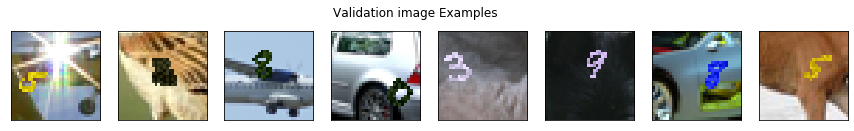

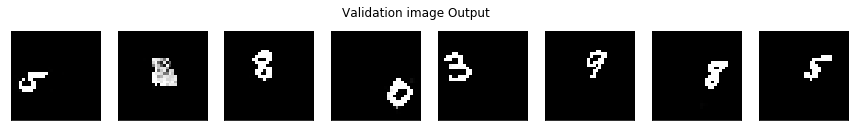

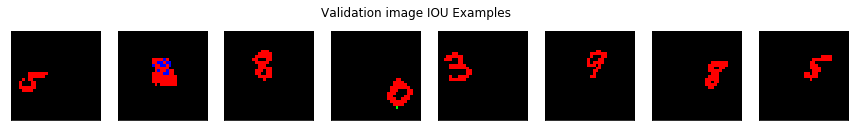

In [12]:
img=images.data.numpy()
img=np.swapaxes(img,1,3)
img=np.swapaxes(img,1,2)

out=outputs.data.numpy()
out=np.reshape(out,(-1,32,32))

lab=labels.data.numpy()
lab=np.reshape(lab,(-1,32,32))

plt.figure(figsize=(15,2))
for i in range(8):
    l1_plot = plt.subplot(1, 8, i + 1)
    l1_plot.imshow(img[i])
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
plt.suptitle('Validation image Examples')
plt.show()

plt.figure(figsize=(15,2))
for i in range(8):
    l1_plot = plt.subplot(1, 8, i + 1)
    l1_plot.imshow(out[i],cmap='gray')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
plt.suptitle('Validation image Output')
plt.show()

out1=copy.deepcopy(out)
out1[out1>0.5]=1
out1[out1<=0.5]=0

plt.figure(figsize=(15,2))
for i in range(0,8,1):
    p=out1[i]
    g=lab[i]
    a=[p==1]
    b=[g==1]
    
    c=(np.array(a)*np.array(b))*1
    anb=np.logical_xor(a,c)*3
    bna=np.logical_xor(b,c)*2
    f=c+anb+bna
    
    brg = cm.get_cmap('brg', 256)
    newcolors = brg(np.linspace(0, 1, 256))
    black = np.array([0, 0, 0, 1])
    green = np.array([0, 1, 0, 1])
    blue = np.array([0, 0, 1, 1])
    red = np.array([1, 0, 0, 1])
    newcolors[0:62, :] = black
    newcolors[62:126, :] = red
    newcolors[190:, :] = green
    newcolors[126:190,:] = blue
    newcmp = ListedColormap(newcolors)

    l1_plot = plt.subplot(1, 8, i + 1)
    l1_plot.imshow(f.reshape(32,32),cmap=newcmp,vmin=0, vmax=3)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    
plt.suptitle('Validation image IOU Examples')
plt.show()

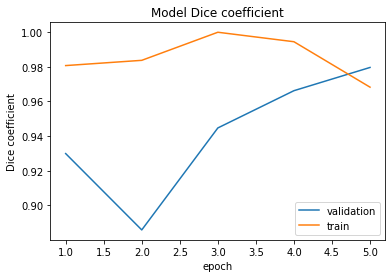

In [13]:
resultsval=np.array(resultsval)
resultstr=np.array(resultstr)

valdice=resultsval[:,1]
valloss=resultsval[:,0]
trdice=resultstr[:,1]
trloss=resultstr[:,0]
x=np.arange(1, len(valdice)+1, 1)
plt.plot(x,valdice)
plt.plot(x,trdice)
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='lower right')
plt.title('Model Dice coefficient')
plt.show()

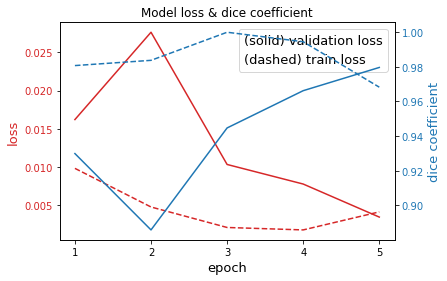

In [14]:
from matplotlib.ticker import (MultipleLocator)

x=np.arange(1, len(valdice)+1, 1)
fig, ax1=plt.subplots()

color='tab:red'
ax1.set_ylabel('loss', color=color,fontsize=13)
ax1.plot(x,valloss,color=color)
ax1.plot(x,trloss, color=color,linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('epoch', fontsize=13)
plt.legend(['(solid) validation loss', '(dashed) train loss'], loc='best', handletextpad=0,
           handlelength=0, fontsize=13)
plt.title('Model loss & dice coefficient')

color='tab:blue'
ax2=ax1.twinx()
ax2.set_ylabel('dice coefficient', color=color, fontsize=13)
ax2.plot(x,valdice,color=color)
ax2.plot(x,trdice,color=color,linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [15]:
targets=yte
inputs = torch.from_numpy(Xte).float()
targets = torch.from_numpy(targets).float()
segs    = torch.from_numpy(Xste).float()

print('Size of inputs: {}'. format(inputs.shape))
print('Size of ground truth: {}'. format(segs.shape))
print(targets.shape)

# Dataloader
teset = data_utils.TensorDataset(inputs, segs)
test_loader = torch.utils.data.DataLoader(teset, batch_size= batch_size, 
                                          shuffle=False, drop_last=True)

Size of inputs: torch.Size([1000, 3, 32, 32])
Size of ground truth: torch.Size([1000, 32, 32])
torch.Size([1000])


In [16]:
result_test = []
total_step = len(test_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(test_loader):
          model.eval()
          images = Variable(images,volatile=True)
          blabels1 = labels
          nlab=blabels1.view(-1,1,16,16)
          labels = Variable(nlab).type(torch.FloatTensor)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
      
          #Calcualte Dice coefficient
          out=outputs.data.numpy()
          out=np.reshape(out,(-1,16,16))
          out1=copy.deepcopy(out)
          out1[out1>0.5]=1
          out1[out1<=0.5]=0
          lab=labels.data.numpy()
          lab=np.reshape(lab,(-1,16,16))
          dice = np.sum(out1[lab==1])*2.0 / (np.sum(out1) + np.sum(lab))
          
          if (i+1) % 31 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], TestLoss: {:.4f}, TestDice: {:.4f}' 
                    .format(epoch+1,num_epochs,i+1, total_step, loss.item(), dice))
  result_test.append([loss.item(),dice]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32, 1, 16, 16])) that is different to the input size (torch.Size([8, 1, 32, 32])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [1/5], Step [31/125], TestLoss: 0.0008, TestDice: 0.9982
Epoch [1/5], Step [62/125], TestLoss: 0.0010, TestDice: 0.9974
Epoch [1/5], Step [93/125], TestLoss: 0.0008, TestDice: 0.9981
Epoch [1/5], Step [124/125], TestLoss: 0.0003, TestDice: 1.0000
Epoch [2/5], Step [31/125], TestLoss: 0.0008, TestDice: 0.9982
Epoch [2/5], Step [62/125], TestLoss: 0.0010, TestDice: 0.9974
Epoch [2/5], Step [93/125], TestLoss: 0.0008, TestDice: 0.9981
Epoch [2/5], Step [124/125], TestLoss: 0.0003, TestDice: 1.0000
Epoch [3/5], Step [31/125], TestLoss: 0.0008, TestDice: 0.9982
Epoch [3/5], Step [62/125], TestLoss: 0.0010, TestDice: 0.9974
Epoch [3/5], Step [93/125], TestLoss: 0.0008, TestDice: 0.9981
Epoch [3/5], Step [124/125], TestLoss: 0.0003, TestDice: 1.0000
Epoch [4/5], Step [31/125], TestLoss: 0.0008, TestDice: 0.9982
Epoch [4/5], Step [62/125], TestLoss: 0.0010, TestDice: 0.9974
Epoch [4/5], Step [93/125], TestLoss: 0.0008, TestDice: 0.9981
Epoch [4/5], Step [124/125], TestLoss: 0.0003, TestD

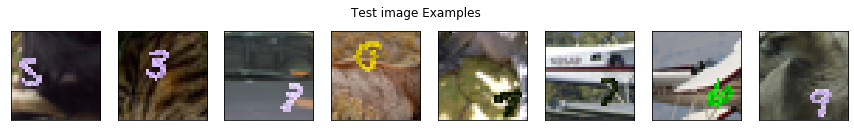

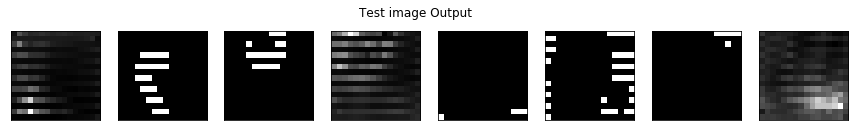

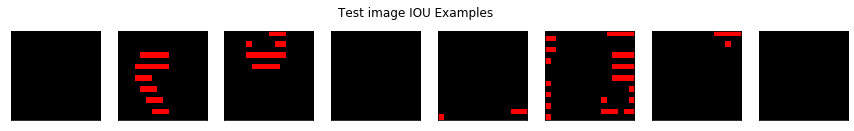

In [17]:
img=images.data.numpy()
img=np.swapaxes(img,1,3)
img=np.swapaxes(img,1,2)

out=outputs.data.numpy()
out=np.reshape(out,(-1,16,16))

lab=labels.data.numpy()
lab=np.reshape(lab,(-1,16,16))

plt.figure(figsize=(15,2))
for i in range(8):
    l1_plot = plt.subplot(1, 8, i + 1)
    l1_plot.imshow(img[i])
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
plt.suptitle('Test image Examples')
plt.show()

plt.figure(figsize=(15,2))
for i in range(8):
    l1_plot = plt.subplot(1, 8, i + 1)
    l1_plot.imshow(out[i],cmap='gray')
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
plt.suptitle('Test image Output')
plt.show()

out1=copy.deepcopy(out)
out1[out1>0.5]=1
out1[out1<=0.5]=0

plt.figure(figsize=(15,2))
for i in range(0,8,1):
    p=out1[i]
    g=lab[i]
    a=[p==1]
    b=[g==1]
    
    c=(np.array(a)*np.array(b))*1
    anb=np.logical_xor(a,c)*3
    bna=np.logical_xor(b,c)*2
    f=c+anb+bna
    
    brg = cm.get_cmap('brg', 256)
    newcolors = brg(np.linspace(0, 1, 256))
    black = np.array([0, 0, 0, 1])
    green = np.array([0, 1, 0, 1])
    blue = np.array([0, 0, 1, 1])
    red = np.array([1, 0, 0, 1])
    newcolors[0:62, :] = black
    newcolors[62:126, :] = red
    newcolors[190:, :] = green
    newcolors[126:190,:] = blue
    newcmp = ListedColormap(newcolors)

    l1_plot = plt.subplot(1, 8, i + 1)
    l1_plot.imshow(f.reshape(16,16),cmap=newcmp,vmin=0, vmax=3)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    
plt.suptitle('Test image IOU Examples')
plt.show()